<a href="https://colab.research.google.com/github/ncy906302/Django-Nginx-uwsgi-setting/blob/master/ocr_for_tflite_for_armm_without_reshape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [1]:
# !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
# !unzip -qq captcha_images_v2.zip
# !mkdir images2
# !cp /content/captcha_images_v2/22d5n.png ./images2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    357      0 --:--:-- --:--:-- --:--:--   358
100 8863k  100 8863k    0     0  8176k      0  0:00:01  0:00:01 --:--:-- 19.9M


In [3]:
data_dir = Path('/content/captcha_images_v2')

images = sorted(list(map(str,list(data_dir.glob('*.png')))))

labels = []
for img in images:
    labels.append(img.split(os.path.sep)[-1].split('.png')[0])

characters = set()
for label in labels:
    for char in label:
        characters.add(char)
print(characters)

print('number of images found: ', len(images))
print('number of labels found: ', len(labels))
print('number of unique characters: ', len(characters))
print('characters present: ', characters)

batch_size = 16

img_width = 200
img_height = 50

max_length = max([len(label) for label in labels])

{'7', '4', 'y', 'd', 'f', '8', 'g', '5', 'e', 'm', 'w', 'p', 'n', '3', '2', 'x', 'c', '6', 'b'}
number of images found:  1040
number of labels found:  1040
number of unique characters:  19
characters present:  {'7', '4', 'y', 'd', 'f', '8', 'g', '5', 'e', 'm', 'w', 'p', 'n', '3', '2', 'x', 'c', '6', 'b'}


In [4]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

def split_data(images,labels,train_size=0.9,shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size*0.9)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train,x_valid,y_train,y_valid

x_train, x_valid, y_train, y_valid = split_data(np.array(images),np.array(labels))

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=3)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))

train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [6]:
for sample_train in train_dataset: break
for sample_val in train_dataset: break

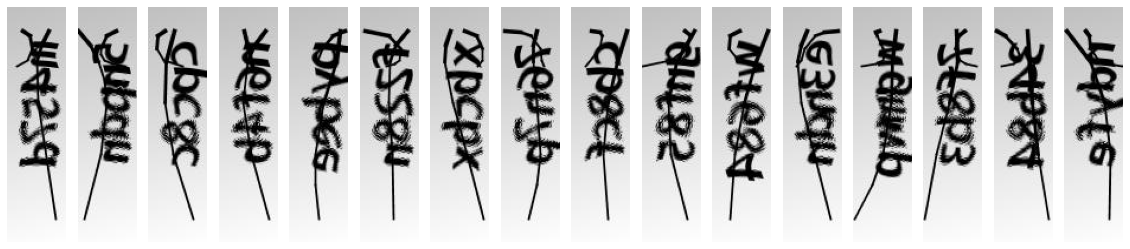

In [7]:
from tensorflow.keras.preprocessing.image import array_to_img

fig, axes = plt.subplots(1, batch_size, figsize=(20, 5))
for idx, ax in enumerate(axes):
  ax.imshow(array_to_img(sample_train["image"][idx]))
  ax.axis("off")

In [8]:
print(sample_train["label"][0])

tf.Tensor([9 1 7 0 3], shape=(5,), dtype=int64)


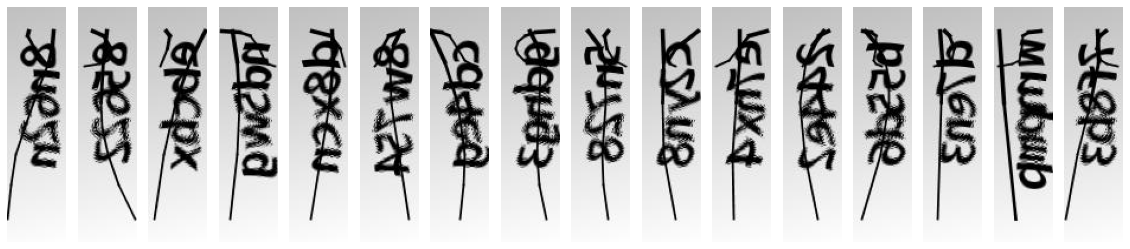

In [9]:
fig, axes = plt.subplots(1, batch_size, figsize=(20, 5))
for idx, ax in enumerate(axes):
  ax.imshow(array_to_img(sample_val["image"][idx]))
  ax.axis("off")

In [9]:
print(sample_val["label"][0])

tf.Tensor([9 1 7 0 3], shape=(5,), dtype=int64)


In [10]:
resnet = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(200,50,3))

94773248/94765736 [==============================] - 1s 0us/step


In [11]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 50, 3)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 56, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 25, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 25, 64)  256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [12]:
class CTCLayer(layers.Layer):
    def __init__(self,name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0],dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len,1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len,1), dtype='int64')

        loss = self.loss_fn(y_true,y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

def build_model():
    input_img = layers.Input(
        shape=(img_width,img_height,3), name='image', dtype='float32'
    )

    resnet = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=input_img)
    # resnet.trainable = False
    labels = layers.Input(name='label', shape=(None,),dtype='float32')
    # new_shape = ((50), (13)*256) 
    # x = layers.Reshape(target_shape=new_shape, name='reshape')(resnet.get_layer('conv2_block2_out').output)
    x = layers.Conv2D(256,(1,13),(1,1),padding='valid',activation='relu')(resnet.get_layer('conv2_block2_out').output)
    
    # x = layers.Lambda(lambda x: tf.squeeze(x,axis=2))(x)
    # x = layers.Dense(128, activation='relu',name='dense1')(x)
    # x = layers.Dropout(0.2)(x)

    # x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    # x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # x = layers.Conv2D(20,kernel_size=(1,1),strides=(1,1),activation='relu')(x)
    
    # x = layers.Lambda(lambda x: tf.squeeze(x,axis=2))(x)

    # x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)
    x = layers.Conv2D(20,kernel_size=(1,1),strides=(1,1),activation='softmax')(x)
    x = layers.Lambda(lambda x: tf.squeeze(x,axis=2))(x)
    # x = layers.Dropout(0.2)(x)

    output = CTCLayer(name='ctc_loss')(labels,x)

    model = keras.models.Model(
        inputs = [input_img,labels], outputs=output, name='ocr_model_v1'
    )
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model


model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 3)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 56, 3)   0           image[0][0]                      
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 25, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 25, 64)  256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [14]:
# prediction_model = keras.models.Model(
#     model.get_layer(name="image").input, model.get_layer(name="lambda_3").output
# )

# converter = tf.lite.TFLiteConverter.from_keras_model(prediction_model) # path to the SavedModel directory
# tflite_model = converter.convert()



# # Save the model.
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)

In [13]:
epochs = 100
early_stopping_patience = 30
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)


# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 [==============================] - 36s 46ms/step - loss: 36.8847 - val_loss: 17.1259
Epoch 2/100
59/59 [==============================] - 2s 29ms/step - loss: 16.3200 - val_loss: 17.3458
Epoch 3/100
59/59 [==============================] - 2s 30ms/step - loss: 16.2056 - val_loss: 17.0389
Epoch 4/100
59/59 [==============================] - 2s 30ms/step - loss: 15.7631 - val_loss: 25.2452
Epoch 5/100
59/59 [==============================] - 2s 29ms/step - loss: 9.4757 - val_loss: 45.5763
Epoch 6/100
59/59 [==============================] - 2s 30ms/step - loss: 2.9794 - val_loss: 49.4716
Epoch 7/100
59/59 [==============================] - 2s 30ms/step - loss: 1.5852 - val_loss: 51.2019
Epoch 8/100
59/59 [==============================] - 2s 30ms/step - loss: 1.0470 - val_loss: 51.1344
Epoch 9/100
59/59 [==============================] - 2s 30ms/step - loss: 0.7801 - val_loss: 49.5646
Epoch 10/100
59/59 [==============================] - 2s 30ms/step - loss: 0.5930 - va

tf.Tensor(
[[17  5 15  1  5]
 [12  9  2 14 15]
 [11 15  3 10 11]
 [ 6  0 10 15 10]
 [ 0  6 12  4 13]
 [ 1  4  5  2 11]
 [14 14 17  9  3]
 [ 4 16  9  8  9]
 [18  8 13 18 11]
 [ 3 10  5  3 13]
 [ 7 10  3  3 10]
 [ 5 16 14 13  4]
 [ 4  7  8  7  8]
 [ 4 14 14 18 12]
 [13  0 13  6 18]
 [ 1 14 12 15  2]], shape=(16, 5), dtype=int64)


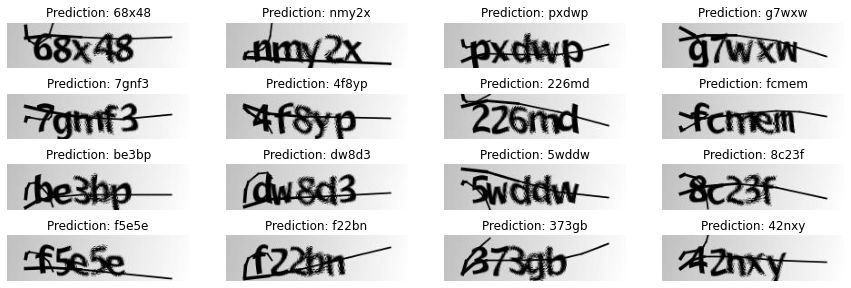

In [14]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="lambda").output
)
# prediction_model.summary()

# A utility function to decode the output of the network

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    print(results)
    # Iterate over the results and get back the text
    output_text = []
    
    for res in results:
        res = res[res!=-1]
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [17]:
!mkdir -p saved_model
prediction_model.save('saved_model/my_model')
!zip -r save_model.zip saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets
  adding: saved_model/ (stored 0%)
  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/my_model/variables/variables.index (deflated 72%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/saved_model.pb (deflated 92%)


In [28]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model/my_model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [25]:
!rm -r saved_model/